In [1]:
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import pandas as pd

In [2]:
class Inventory_Simulation:
    def __init__(self, lambda_rate, s, S, L, h, c_func, demand_function, simulation_time, initial_inventory,product_price):
        #time variable
        self.t = 0.0
        
        #system variables
        #the amount of inventory on hand
        self.x = initial_inventory
        #the amount on order
        self.y = 0

        #counter variables
        #the total amount of ordering costs by t
        self.C = 0
        #the total amount of inventory holding costs by t
        self.H = 0
        #the total amount of revenue earned by time t
        self.R = 0

        #model parameters
        self.lambda_rate = lambda_rate # Tasa de llegada de clientes (Poisson)
        #min inventory  
        self.s = s       
        #max inventory               
        self.S = S       
        #order delivery time               
        self.L = L
        #inventory hold cost per unit                      
        self.h = h
        #order function cost                      
        self.c_func = c_func
        #demand function            
        self.demand_function = demand_function  # demand_func
        #simulation time
        self.simulation_time = simulation_time
        #product price
        self.r = product_price

        #events queue
        self.events = []
        
    def new_client_arrival(self):
        time = random.expovariate(1/self.lambda_rate)
        heapq.heappush(self.events, (self.t + time, 'client'))
    
    def new_order_arrival(self):
        delivery_time = self.t + self.L
        heapq.heappush(self.events, (delivery_time, 'order'))
    
    def run(self):
        self.new_client_arrival()
        while self.t < self.simulation_time and self.events:
            evento = heapq.heappop(self.events)
            event_time, event_type = evento[0], evento[1]
            
            self.H += self.x * (event_time - self.t) * self.h
            self.t = event_time
            
            if event_type == 'client':
                d = self.demand_function()
                w = min(d, self.x)
                self.R += w * self.r
                self.x -= w
                
                if self.x < self.s and self.y == 0:
                    order_amount = self.S - self.x
                    self.y = order_amount
                    self.new_order_arrival()
            
                self.new_client_arrival()
            
            elif event_type == 'order':
                self.C += self.c_func(self.y)
                self.x += self.y
                self.y = 0

        if self.t < self.simulation_time:
            self.H += self.x * self.h * (self.simulation_time - self.t)
            self.t = self.simulation_time
            
        return (self.R,self.C,self.H)

In [3]:
def uniform_dist():
    return random.randint(1, 10)  

def order_cost(amount):
    return 25 + 4 * amount

def delivery_time():
    return random.randint(20,30)

Veamos como se correlacionan los datos:

<Axes: >

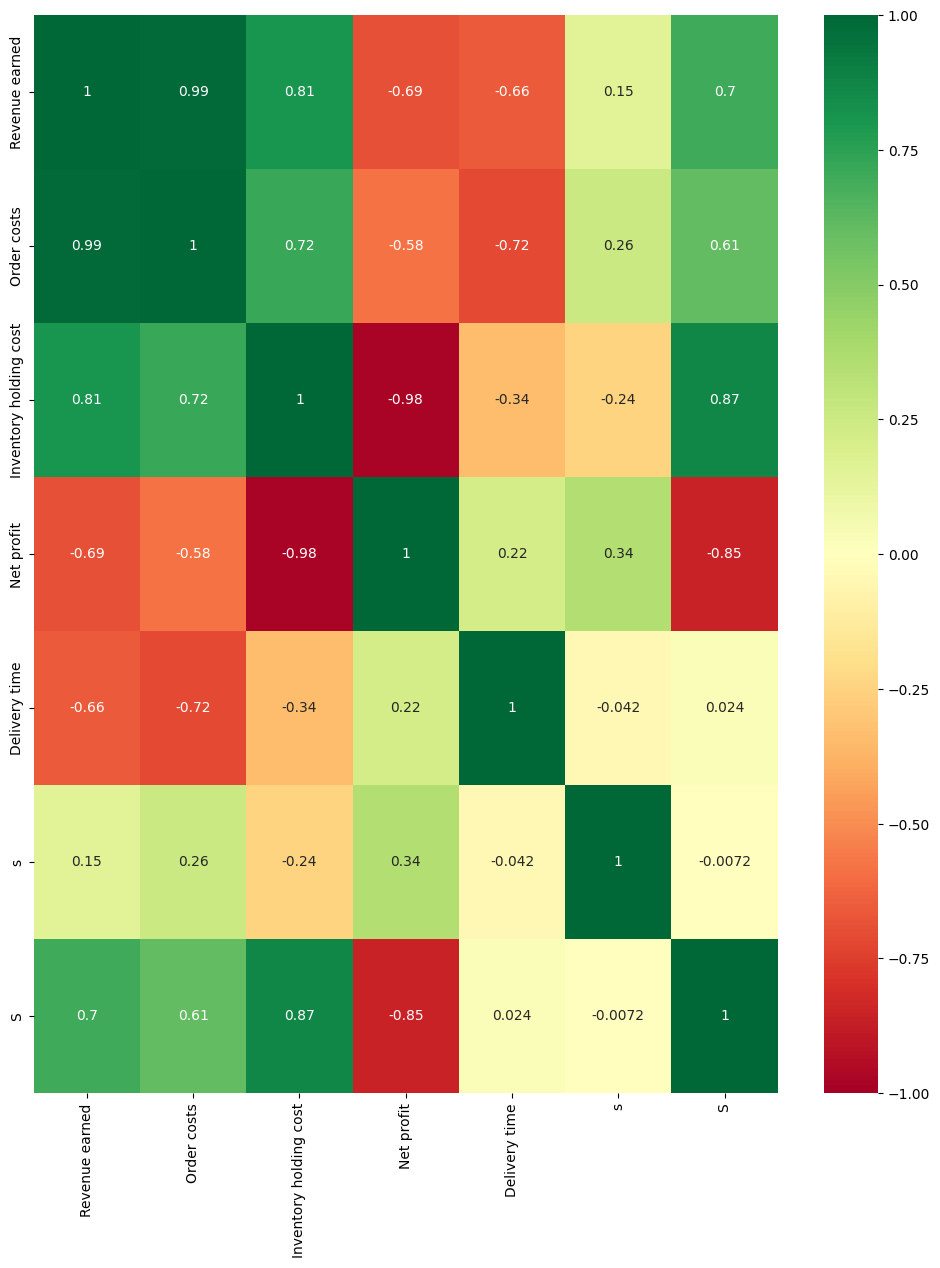

In [4]:
corr = []

for _ in range(1000):
    L = delivery_time()
    s = random.randint(20,60)
    S = random.randint(61,100)
    sim = Inventory_Simulation(
        lambda_rate=2,
        s= s,
        S= S,
        L= L,
        h = 1,
        c_func=order_cost,
        demand_function=uniform_dist,
        simulation_time=10080, #time in minutes
        initial_inventory = 100,
        product_price = 10
    )
    R, C, H = sim.run()
    corr.append({"Revenue earned": R,"Order costs":C ,"Inventory holding cost":H,"Net profit": R-C-H,"Delivery time":L,"s":s,"S":S})
df_corr = pd.DataFrame(corr)
variables = ["Revenue earned", "Order costs", "Inventory holding cost", "Net profit", "Delivery time","s","S"]

corr_matrix = df_corr[variables].corr()

plt.figure(figsize=(12, 14))
sns.heatmap(corr_matrix,annot=True,vmin=-1,vmax=1, cmap='RdYlGn')

Veamos como distribuyen los datos para: 

s: Mínimo inventario de 30 unidades

S: Máximo inventario de 100 unidades

L: tiempo de entrega 30 minutos

In [5]:
data = []
for _ in range(1000):
    sim = Inventory_Simulation(
        lambda_rate=2,
        s= 30,
        S= 100,
        L= 30,
        h = 1,
        c_func=order_cost,
        demand_function=uniform_dist,
        simulation_time=10080, #time in minutes
        initial_inventory = 100,
        product_price = 10
    )
    R, C, H= sim.run()
    data.append(R - C - H)
net_profit1 = np.array(data)


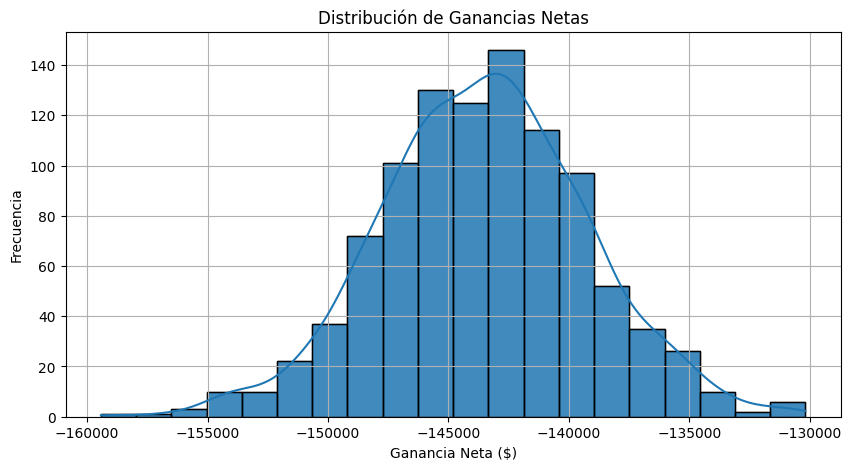

Media: $-143539.74
Desviación estándar: $4282.94


In [6]:
plt.figure(figsize=(10, 5))
plt.hist(net_profit1, bins=20, edgecolor='k', alpha=0.7)
sns.histplot(net_profit1, bins=20, kde=True, edgecolor='k', alpha=0.5)
plt.title('Distribución de Ganancias Netas')
plt.xlabel('Ganancia Neta ($)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

print(f"Media: ${np.mean(net_profit1):.2f}")
print(f"Desviación estándar: ${np.std(net_profit1):.2f}")

Veamos si las ganancias siguen una distribución normal:

Prueba de Normalidad Shapiro-Wilk , solo para una cantidad de datos <= 5000 para mayor efectividad

In [7]:
stat, p_valor = scipy.stats.shapiro(net_profit1)
print(f"p-valor: {p_valor:.4f}")
if p_valor < 0.05:
    print("Los datos NO siguen una distribución normal")
else:
    print("Los datos podrían ser normales")

p-valor: 0.4960
Los datos podrían ser normales


Prueba normalidad de Anderson-Darling para mayor cantidad de datos

In [8]:
from scipy.stats import anderson

result = anderson(net_profit1)
print(f'Estadístico de Anderson-Darling: {result.statistic}')
print(f'Valores críticos: {result.critical_values}')

# Comparar el estadístico de la prueba con los valores críticos
if result.statistic > result.critical_values[2]:  # Nivel de significancia 0.05
    print("Los datos no siguen una distribución normal.")
else:
    print("Los datos siguen una distribución normal.")

Estadístico de Anderson-Darling: 0.3520491311571732
Valores críticos: [0.574 0.653 0.784 0.914 1.088]
Los datos siguen una distribución normal.


-Hipótesis: Un aumento de la capacidad mínima del inventario aumenta significativamente el costo de los pedidos y aumenta significativamente el costo del almacenamiento:

In [9]:
def simulationFunc(s:int,N:int):
    C_data = []
    H_data = []
    net_data = []
    for _ in range(N):
        sim = Inventory_Simulation(
            lambda_rate=2,
            s= s,
            S= 100,
            L= 15,
            h = 1,
            c_func=order_cost,
            demand_function=uniform_dist,
            simulation_time=10080, #time in minutes
            initial_inventory = 100,
            product_price = 10
        )
        R, C, H = sim.run()
        C_data.append(C)
        H_data.append(H)
        net_data.append(R-C-H)
    C_data = np.array(C_data)
    H_data = np.array(H_data)
    net_data = np.array(net_data)
    return C_data , H_data, net_data

In [10]:
C_data1, H_data1,net_data = simulationFunc(30,1000)
C_data2, H_data2,net_data= simulationFunc(50,1000)

t_stat, p_valor = scipy.stats.ttest_ind(C_data1, C_data2)

print(f"Estadístico t: {t_stat:.3f}")
print(f"Valor p: {p_valor:.3f}")
if p_valor < 0.05:
    print("Diferencias significativas entre los costos de pedidos")
else:
    print("Sin diferencias significativas en los costos de pedidios")

t_stat, p_valor = scipy.stats.ttest_ind(H_data1, H_data2)

print(f"Estadístico t: {t_stat:.3f}")
print(f"Valor p: {p_valor:.3f}")
if p_valor < 0.05:
    print("Diferencias significativas entre los costos de Almacenamiento")
else:
    print("Sin diferencias significativas en los costos de Almacenamiento")

Estadístico t: -274.307
Valor p: 0.000
Diferencias significativas entre los costos de pedidos
Estadístico t: -117.526
Valor p: 0.000
Diferencias significativas entre los costos de Almacenamiento


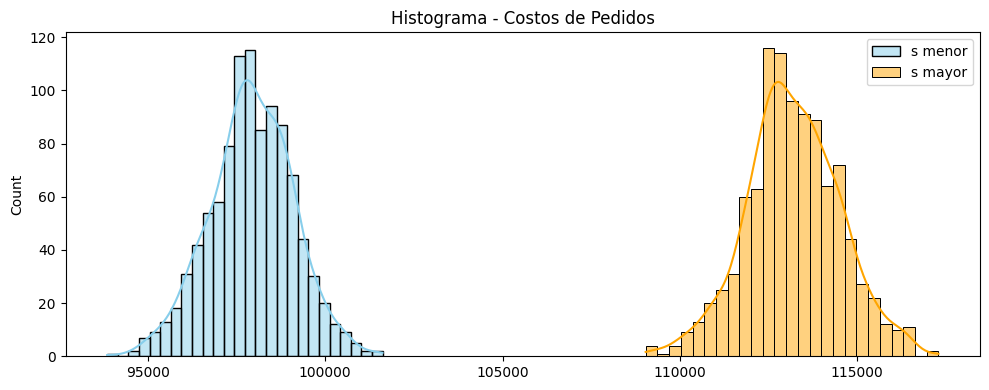

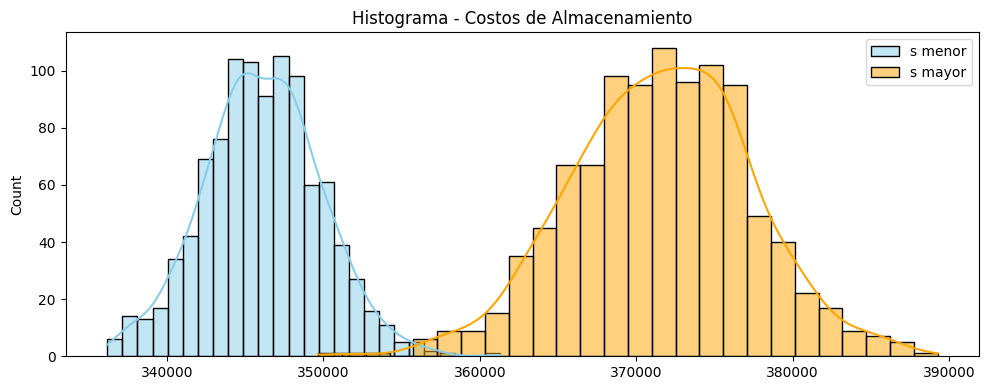

In [11]:
def plot_comparison(data1, data2, title):
    plt.figure(figsize=(10, 4))
        
    #plt.subplot(1, 2, 2)
    sns.histplot(data1, color="skyblue", label="s menor", kde=True)
    sns.histplot(data2, color="orange", label="s mayor", kde=True)
    plt.title(f"Histograma - {title}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_comparison(C_data1, C_data2, "Costos de Pedidos")
plot_comparison(H_data1, H_data2, "Costos de Almacenamiento")